# Data Exploration & Feature Engineering

# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Loading data:
The files can be downloaded from: https://datahack.analyticsvidhya.com/contest/introduction-to-data-science-regression/

In [2]:
#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 12) (5681, 11) (14204, 12)


C:\Users\Sourav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
#Check missing values:
data.apply(lambda x: sum(x.isnull()))

ID                              0
Item_Fat_Content                0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [5]:
#Numerical data summary:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [6]:
#Number of unique values in each:
data.apply(lambda x: len(x.unique()))

ID                           14204
Item_Fat_Content                 5
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [7]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['ID','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

# 2. Data Cleaning

### Imputation

In [8]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull()
#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d'%sum(miss_bool))

# Impute missing values
#      The dataset with continuous features has missing data in all the features. 
#      We impute with the most frequent values or apply median
#data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace = True)
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Weight'].apply(lambda x: data.Item_Weight.mean())
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [9]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]))
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'%sum(miss_bool))

data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 4016


C:\Users\Sourav\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


0


# 2. Feature Engineering:

### Step1: Consider combining categories in Outlet_Type

In [10]:
#Check the mean sales by type:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


### Step2: Modify Item_Visibility

In [11]:
#Determine average visibility of a product
#visibility_avg = data['Item_Visibility'].mean()

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)
print('Number of 0 values initially: %d'%sum(miss_bool))

# Impute missing values
#      The dataset with continuous features has missing data in all the features. 
#      We impute with the most frequent values or apply median
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Visibility'].apply(lambda x: data.Item_Visibility.mean())
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [12]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/data.Item_Visibility.mean(), axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.000000
std          0.693971
min          0.051042
25%          0.473246
50%          0.890237
75%          1.342733
max          4.689008
Name: Item_Visibility_MeanRatio, dtype: float64


### Step 3: Create a broad category of Type of Item

In [13]:
#Item type combine:
#data['ID'].value_counts()
data['Item_Type_Combined'] = data['ID'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### Step 4: Determine the years of operation of a store

In [14]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### Step 5: Modify categories of Item_Fat_Content

In [15]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [16]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Step 6: Numerical and One-Hot Coding of Categorical variables

In [17]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [18]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined'])

In [19]:
data.dtypes

ID                            object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
dtype: object

In [20]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


### Step 7: Exporting Data

In [21]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\Sourav\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


   ### Read train and test set

In [22]:
train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")

# Model Building

##### Function: modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename)

In [23]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['ID']
#from sklearn import cross_validation, metrics
from sklearn.model_selection import cross_validate as cv
from sklearn import metrics
from sklearn.model_selection import cross_val_score as cvs

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    #cv_score = cv.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    
    scoring = ['neg_mean_squared_error']
    cv_score = cv(alg, dtrain[predictors], dtrain[target], cv=20, scoring=scoring)
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #print(model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    
    cv_score = np.sqrt(np.abs(cv_score['train_neg_mean_squared_error']))
    print("CV Score : Mean ~ %.4g | Std ~ %.4g | Min ~ %.4g | Max ~ %.4g" %(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv("alg1.csv",index=False)
    submission.to_csv(filename, index=False)

#### Decision Tree Model


Model Report
RMSE : 1059
CV Score : Mean ~ 1060 | Std ~ 2.772 | Min ~ 1055 | Max ~ 1066


C:\Users\Sourav\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


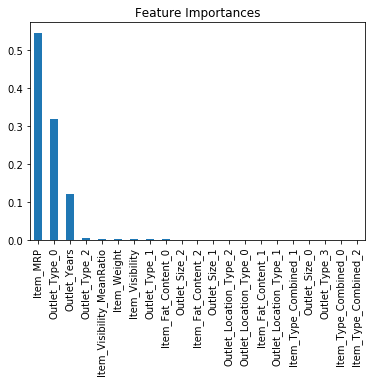

In [24]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'Submission_DT_Model.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

### Conclusion: 
So far based on our analysis, the best model is the one using Decision Tree with RMSE 1059 and the mean CV error 1060.